In [63]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from tensorflow import keras

import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 가져오기

In [13]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [14]:
data.sample(10)

,headlines,text
65943,Luxury fashion brand Gucci bans fur in its col...,Italian luxury fashion brand Gucci's CEO Marco...
17420,"Video shows Delhi cop's son hitting, kicking girl","A video of a man, identified as Delhi policema..."
43214,"Cristiano Ronaldo scores 4 goals, his 50th car...",Real Madrid forward Cristiano Ronaldo on Sunda...
24267,Japan executes 6 more cult members over 1995 c...,Japan on Thursday executed six remaining membe...
56356,"Nawazuddin, Vijay's 'Monsoon Shootout' hits th...",Nawazuddin Siddiqui and Vijay Varma's film 'Mo...
87355,Highest whisky bar serves 1st Chivas custom sc...,Bangkok's newly opened Alfresco 64 - A Chivas ...
25756,Google may face record fine by EU over Android...,Google is reportedly facing a record European ...
67569,Govt raises natural gas price for first time i...,The government on Friday hiked the domestic na...
6857,BJP worker shot dead in West Bengal,BJP booth level leader Sandip Ghosh was allege...
2890,Rakesh Roshan is a fighter: PM to Hrithik on d...,After actor Hrithik Roshan revealed that his f...


## 데이터 전처리

### 데이터 중복 및 결측치 처리

In [15]:
data.shape

(98401, 2)

In [16]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [17]:
data.drop_duplicates(subset=['text'], inplace=True)
data.shape

(98360, 2)

In [23]:
# headlines 와 text가 동시에 중복인 경우는 없음
data[data.duplicated(['headlines', 'text'])]

,headlines,text


In [24]:
# 결측치 : 0
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 데이터 정규화 사전 및 불용어 리스트 가져오기
- 정규화 사전 출처 : [🔗](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
- nltk 패키지 사용법 : [🔗](https://datascienceschool.net/03%20machine%20learning/03.01.01%20NLTK%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html)

In [25]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [29]:
# nltk에서 제공하는 불용어 리스트
# 불용어 리스트 추출
print(len(stopwords.words('english')))
stopwords.words('english')[:10]

179


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### 데이터 전처리
1. 텍스트 소문자화
2. html 태그 제거
3. 괄호 내 문자열 제거
4. 쌍따옴표 제거
5. 약어 정규화
6. 소유격 제거
7. 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
8. 불용어 제거 (headlines는 미제거)

#### 데이터 전처리 방식 정리 (예시)

In [38]:
# 데이터 전처리 방식 정리 (예시)
sentence_origin = data.loc[104]['text']
print(sentence_origin)

A team of IIT-Roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. Instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor RP Saini said. "Flowing water can generate hundred times more power than wind of same velocity," Saini added.


In [40]:
sentence1 = sentence_origin.lower()
print(sentence_origin[:30])
print(sentence1[:30])

A team of IIT-Roorkee scientis
a team of iit-roorkee scientis


In [42]:
sentence2 = BeautifulSoup(sentence1, 'lxml').text
print(sentence2)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. "flowing water can generate hundred times more power than wind of same velocity," saini added.


In [44]:
sentence3 = re.sub(r'\([^)]*\)', '', sentence2)
print(sentence3)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. "flowing water can generate hundred times more power than wind of same velocity," saini added.


In [46]:
sentence4 = re.sub('"', '', sentence3)
print(sentence4)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. flowing water can generate hundred times more power than wind of same velocity, saini added.


In [48]:
sentence5 = ' '.join([contractions[t] if t in contractions else t for t in sentence4.split(" ")])
print(sentence5)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. flowing water can generate hundred times more power than wind of same velocity, saini added.


In [49]:
sentence6 = re.sub(r"'s\b","",sentence5)
print(sentence6)

a team of iit-roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers. instead of using water falling from height to turn turbines like in traditional dams, the prototype uses velocity of flowing river, professor rp saini said. flowing water can generate hundred times more power than wind of same velocity, saini added.


In [51]:
sentence7 = re.sub("[^a-zA-Z]", " ", sentence6)
print(sentence7)

a team of iit roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers  instead of using water falling from height to turn turbines like in traditional dams  the prototype uses velocity of flowing river  professor rp saini said  flowing water can generate hundred times more power than wind of same velocity  saini added 


In [52]:
sentence8 = re.sub('[m]{2,}', 'mm', sentence7)
print(sentence8)

a team of iit roorkee scientists is testing a floating device that can generate electricity from flowing surface water of rivers  instead of using water falling from height to turn turbines like in traditional dams  the prototype uses velocity of flowing river  professor rp saini said  flowing water can generate hundred times more power than wind of same velocity  saini added 


In [53]:
token = ' '.join(word for word in sentence8.split() if not word in stopwords.words('english') if len(word) > 1)
print(token)

team iit roorkee scientists testing floating device generate electricity flowing surface water rivers instead using water falling height turn turbines like traditional dams prototype uses velocity flowing river professor rp saini said flowing water generate hundred times power wind velocity saini added


#### 데이터 전처리 함수 정의 및 전처리 시작

In [58]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [62]:
# 비교 예시
temp = data.loc[45]['text']
print('원본 : {}\n'.format(temp))
print('변환 : {}'.format(preprocess_sentence(temp, True)))

원본 : Union Minister Anantkumar Hegde took a dig at Congress President Rahul Gandhi by calling him a "hybrid specimen" who has no clue about religion. "A father who's...Muslim, a mother who's...Christian and the son is supposed to be...Brahmin. How is that even possible?" he said. He added such "hybrid specimen" cannot be found in any laboratory in the world.

변환 : union minister anantkumar hegde took dig congress president rahul gandhi calling hybrid specimen clue religion father muslim mother christian son supposed brahmin even possible said added hybrid specimen cannot found laboratory world


In [64]:
clean_headlines = []
clean_text = []

for x in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(x, False))

for x in tqdm(data['text']):
    clean_text.append(preprocess_sentence(x, True))

100%|██████████| 98360/98360 [09:34<00:00, 171.20it/s]


In [65]:
clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [66]:
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [67]:
data['headlines'] = clean_headlines
data['text'] = clean_text

In [71]:
print(data.shape)
data.head()

(98360, 2)


,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


In [70]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 데이터 Max_len 설정

In [72]:
headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

In [73]:
print('요약의 최소 : {}'.format(np.min(headlines_len)))
print('요약의 최대 : {}'.format(np.max(headlines_len)))
print('요약의 평균 : {}'.format(np.mean(headlines_len)))

print('텍스트의 최소 : {}'.format(np.min(text_len)))
print('텍스트의 최대 : {}'.format(np.max(text_len)))
print('텍스트의 평균 : {}'.format(np.mean(text_len)))

요약의 최소 : 1
요약의 최대 : 16
요약의 평균 : 9.299532330215534
텍스트의 최소 : 1
텍스트의 최대 : 60
텍스트의 평균 : 35.09968483123221


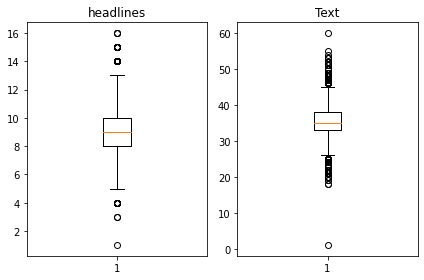

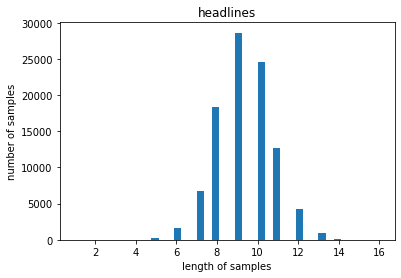

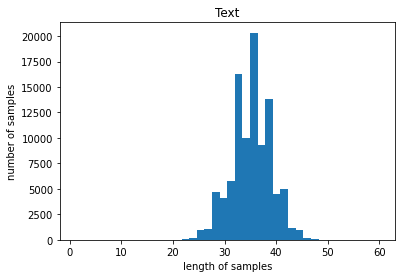

In [79]:
# boxplot을 이용한 IQR 시각화
plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

# 히스토그램 시각화
plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [80]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [89]:
# 임의의 max_len 선정
headlines_max_len = 11
text_max_len = 40

below_threshold_len(headlines_max_len,  data['headlines'])
below_threshold_len(text_max_len, data['text'])

전체 샘플 중 길이가 11 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0


In [90]:
# max_len 길이 이하만 추출
# 98360 -> 85843
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

data.shape

(85843, 2)

### encoder, decoder 데이터 정의

In [93]:
# headline 토큰에는 훈련을 위한 시작 및 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [94]:
# 마지막에 eostoken이 잘 붙었는지 확인
data['decoder_target'][0]

'upgrad learner switches to career in ml al with salary hike eostoken'

In [95]:
# encoder decoder input target 정의
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

### 데이터 분리

In [98]:
# shuffle을 이용한 데이터 샘플 순서 무작위 정의
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
indices

array([20454, 60067, 39351, ..., 59036, 24551, 58614])

In [99]:
# 테스트 데이터 수 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [101]:
# train, test 데이터 분리
# train 68675게, test 17168개로 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

encoder_input_train.shape, encoder_input_test.shape

((68675,), (17168,))

## 

In [102]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [103]:
# 토크나이저 정의 및 단어 집합 생성(train encode 데이터)
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [105]:
# 등장 빈도 수 기준
threshold = 7

# 총 단어 수
total_cnt = len(src_tokenizer.word_index)
# threshold보다 적은 단어 수
rare_cnt = 0
# 단어의 총 빈도 수 및 rare 빈도 수
total_freq = 0
rare_freq = 0


# key: 단어, value: 빈도 수
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면 rare 변수에 추가
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64672
등장 빈도가 6번 이하인 희귀 단어의 수: 44060
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 20612
단어 집합에서 희귀 단어의 비율: 68.12840178129639
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7769854673940486


In [106]:
# 단어 수 : 64672
# 등장 빈도 6회 이하 단어 수 : 44060 (68.12%)
# 7회 이상 : 64672 - 44080 = 20612

# 단어 집합 크기 제한(20000)을 통한 단어 집합 생성
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
# text to int(정수 시퀀스)
# train test 모두 처리
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [110]:
print(encoder_input_train[:3])

[[5, 89, 59, 154, 50, 415, 2259, 3120, 5, 452, 252, 1, 1820, 582, 586, 986, 2402, 2873, 1374, 1004, 10585, 2032, 3120, 503, 13136, 5, 8377, 314, 217, 1128, 1076, 4419, 4420, 1491], [778, 568, 459, 382, 201, 4778, 18022, 66, 2555, 420, 18022, 1091, 2555, 635, 295, 1257, 104, 512, 6861, 2180, 4614, 5033, 282, 1091, 174, 4653, 92, 295, 1257, 18022, 2555, 420, 3362], [810, 76, 552, 721, 75, 131, 1160, 2738, 13137, 270, 708, 5933, 7939, 552, 2450, 214, 163, 214, 87, 2303, 37, 602, 1375, 552, 721, 376, 163, 1555, 342, 6158, 552, 721, 1610, 4570]]


In [111]:
# decoder input에도 같은 순서 반복
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [112]:
def check_vocab_freq(threshold, tokenizer):
    threshold = threshold
    total_cnt = len(tokenizer.word_index)
    rare_cnt = 0
    total_freq = 0
    rare_freq = 0

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tar_tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [113]:
# threshold=6일 때
check_vocab_freq(6, tar_tokenizer)

단어 집합(vocabulary)의 크기 : 28533
등장 빈도가 5번 이하인 희귀 단어의 수: 18822
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9711
단어 집합에서 희귀 단어의 비율: 65.96572389864367
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.207217338408729


In [117]:
# threshold=8일 때
check_vocab_freq(8, tar_tokenizer)

단어 집합(vocabulary)의 크기 : 28533
등장 빈도가 7번 이하인 희귀 단어의 수: 20335
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8198
단어 집합에서 희귀 단어의 비율: 71.2683559387376
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.613640579768501


In [118]:
# threshold=8일 때 기준으로 단어 집합 크기 제한
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 15, 743, 193, 4, 522, 1182, 3, 2338], [1, 617, 220, 98, 1484, 8, 3226, 356, 2128, 7], [1, 487, 4104, 1037, 634, 5161, 3, 216, 1453], [1, 2129, 292, 1168, 5976, 1152, 3, 766, 7, 1153, 1298], [1, 948, 1008, 538, 1687]]
target
decoder  [[15, 743, 193, 4, 522, 1182, 3, 2338, 2], [617, 220, 98, 1484, 8, 3226, 356, 2128, 7, 2], [487, 4104, 1037, 634, 5161, 3, 216, 1453, 2], [2129, 292, 1168, 5976, 1152, 3, 766, 7, 1153, 1298, 2], [948, 1008, 538, 1687, 2]]


In [119]:
# headlines의 길이가 0인 경우 추출
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0


In [121]:
decoder_input_train[drop_train[0]]

[1]

In [122]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

# test도 수행해야지만 현재 삭제할 테스트 데이터는 없으므로 제외
#encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
#decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
#decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168
